In [36]:
import numpy as np

np.random.seed(123)
#k1 = root height - internal node height
#k2 = internal node height
#T = 0,1,2 three topologies
#i = num of samples

# Kingman’s n-coalescent, prob(k1,y,T), where T defines y and k1  
def prob(k1, k2):
    Ne = 1 # 2N
    # exp(−u_k * k(k−1) / 2) = -y*3*(3-1)/2 or -k1*2*(2-1)/2
    p = (1/Ne) * np.exp(-3*k2/Ne) * (1/Ne) * np.exp(-k1/Ne) 
    return p
    
# propose
def getProposal(k1, k2, T):
    k1_ = k1; k2_ = k2; T1 = T
    rand = np.random #.uniform(0, 1) [0, 1)
    if (rand.uniform(0, 1) > 0.5):
        #change k1        
        k1_ = k1 + rand.uniform(0, 1) - 0.5
        if (k1_ < 0):
            #change T
            if (rand.uniform(0, 1) > 0.5):
                T1 = np.mod((T+1), 3)
            else:
                T1 = np.mod((T+2), 3)
            k1_ = -k1_
    else:
        #change k2
        k2_ = k2 + rand.uniform(0, 1) - 0.5
    return k1_, k2_, T1

# access proposal
def accept(k1, k2, k1_, k2_):
    if (k1_ < 0 or k2_ < 0):
        return False #reject
    ratio = prob(k1_,k2_) / prob(k1,k2) 
    if (ratio > np.random.uniform(0, 1)):
        return True  #accept
    else:
        return False #reject


# MCMC sampling
samples = 1000
k1 = k2 = 1 
T = i = 0
listK1, listK2, listT = ([] for i in range(3))
while i < samples:    
    k1_, k2_, T1 = getProposal(k1, k2, T)
    isAccepted = accept(k1, k2, k1_, k2_)
    if (isAccepted):
        k1 = k1_;
        k2 = k2_;
        T = T1;
    listK1.append(k1)
    listK2.append(k2)
    listT.append(T)
    i += 1

print("sample size =", samples)
print("len(k1)", len(listK1), "== len(k2)", len(listK2), "is", len(listK1) == len(listK2))
#print(*listK1, sep=', ')
#print(*listK2, sep=', ')
#print(*listT, sep=', ')

sample size =  1000
len(k1) 1000 == len(k2) 1000 is True


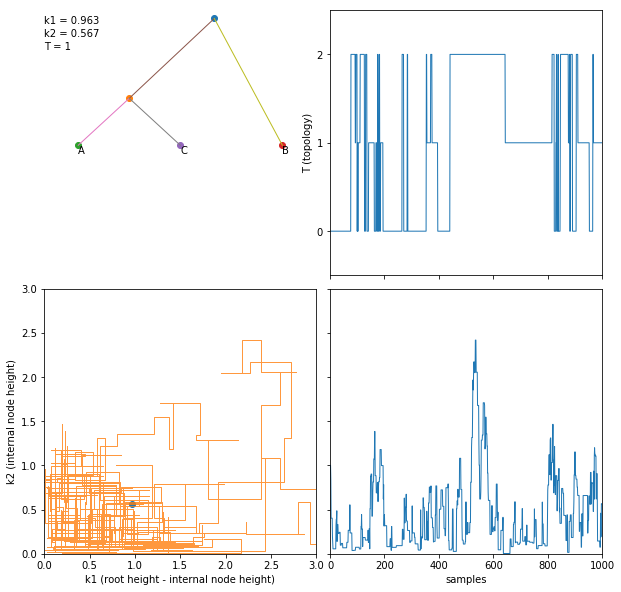

In [35]:
import matplotlib.pyplot as plt
from matplotlib import animation

fig = plt.figure(figsize=(10,10))
k1_width = k2_width = (0, 3)
tree_width = (0, 2)
tree_height = (-1.1, 2.1)
states_width = (0, samples)
# tree panel
ax1 = fig.add_subplot(221, xlim=tree_width, ylim=tree_height)
ax1.axis('off')
# topology trace
ax2 = fig.add_subplot(222, xlim=states_width, ylim=(-0.5, 2.5), ylabel='T (topology)')
ax2.set_xticklabels([])
ax2.yaxis.set_ticks(np.arange(0, 3, step=1))
# x, y
ax3 = fig.add_subplot(223, xlim=k1_width, ylim=k2_width, xlabel='k1 (root height - internal node height)', 
                      ylabel='k2 (internal node height)')
# y trace
ax4 = fig.add_subplot(224, xlim=states_width, ylim=k2_width, xlabel='samples')
ax4.set_yticklabels([])
fig.subplots_adjust(wspace=0.05, hspace=0.05)

line1, = ax2.plot([], [], lw=1)
line2, = ax4.plot([], [], lw=1)
# dot
line3, = ax3.plot([], [], 'o', lw=3)
line4, = ax3.plot([], [], lw=1, alpha=.8)
# tree topology based on (A,B),C => A 3, B 4, C 5, AB, 2, ABC 1
node1, = ax1.plot([], [], 'o', lw=2)
node2, = ax1.plot([], [], 'o', lw=3)
node3, = ax1.plot([], [], 'o', lw=2)
node4, = ax1.plot([], [], 'o', lw=2)
node5, = ax1.plot([], [], 'o', lw=2)
edge12, = ax1.plot([], [], lw=1)
edge23, = ax1.plot([], [], lw=1)
edge24, = ax1.plot([], [], lw=1)
edge15, = ax1.plot([], [], lw=1)
lines = [line1, line2, line3, line4, edge12, edge23, edge24, edge15, 
         node1, node2, node3, node4, node5]
# text
k1_text = ax1.text(0, 0.95, '', transform=ax1.transAxes)
k2_text = ax1.text(0, 0.90, '', transform=ax1.transAxes)
T_text = ax1.text(0, 0.85, '', transform=ax1.transAxes)

x3 = 0.25; x4 = 1.0; x5 = 1.75; y = 0

tip3_label = ax1.text(x3, y-0.1, 'A')
tip4_label = ax1.text(x4, y-0.1, 'B')
tip5_label = ax1.text(x5, y-0.1, 'C')

# tree T=0 : (A,B),C => A 3, B 4, C 5
# tree T=1 : (A,C),B => A 3, B 5, C 4
# tree T=2 : (B,C),A or (C,B),A => A 5, B 3, C 4
def plotTipsByTopology(T, y):
    #change label based on T
    if (T==0):
        node3.set_data(x3, y) # tip 3
        node4.set_data(x4, y) # tip 4
        node5.set_data(x5, y) # tip 5
        tip3_label.set_position((x3, y-0.1))
        tip4_label.set_position((x4, y-0.1))
        tip5_label.set_position((x5, y-0.1))
    elif (T==1):
        node3.set_data(x3, y) # tip 3
        node5.set_data(x4, y) # tip 4
        node4.set_data(x5, y) # tip 5
        tip3_label.set_position((x3, y-0.1))
        tip5_label.set_position((x4, y-0.1)) # C
        tip4_label.set_position((x5, y-0.1)) # B
    elif (T==2):
        node4.set_data(x3, y) # tip 3
        node5.set_data(x4, y) # tip 4
        node3.set_data(x5, y) # tip 5
        tip4_label.set_position((x3, y-0.1)) # B
        tip5_label.set_position((x4, y-0.1)) # C
        tip3_label.set_position((x5, y-0.1)) # A
    else:
        raise Exception("Not recognised topology T =", T)    

def init():
    for line in lines:
        line.set_data([], [])
    return lines

xNode2 = 0.625 # fix internal node 2 x
xRoot = 1.25; yRoot = 2 # fixed
def animate(i):
    _k1 = listK1[i]; _k2 = listK2[i]; _T = listT[i]
    line1.set_data(range(i), listT[:i])
    line2.set_data(range(i), listK2[:i])
    line3.set_data(_k1, _k2)
    line4.set_data(listK1[:i], listK2[:i])
    #tree 
    _y2 = yRoot-_k1
    _y = yRoot-_k1-_k2
    node1.set_data(xRoot, yRoot) # root
    node2.set_data(xNode2, _y2) # internal node 
    edge12.set_data([xRoot, xNode2], [yRoot, _y2])
    edge23.set_data([xNode2, x3], [_y2, _y])
    edge24.set_data([xNode2, x4], [_y2, _y])
    edge15.set_data([xRoot, x5], [yRoot, _y])
    # text
    k1_text.set_text('k1 = %.3f' % _k1)
    k2_text.set_text('k2 = %.3f' % _k2)
    T_text.set_text('T = %.0f' % _T)
    plotTipsByTopology(_T, _y)
    return lines

# interval : Delay between frames in milliseconds. Defaults to 200.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=samples, 
                               interval=10, blit=True, repeat=True)

anim.save('TreeSpace3Taxa.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
plt.show()



In [43]:
from IPython.display import HTML
from base64 import b64encode

video = open("TreeSpace3Taxa.m4p", "rb").read()
video_encoded = b64encode(video).decode('ascii')
video_tag = '<video controls alt="TreeSpace3Taxa" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(data=video_tag)


FileNotFoundError: [Errno 2] No such file or directory: 'TreeSpace3Taxa.m4p'